# Obtaining deflection in time for a sinc excited tip interacting with a viscoelastic solid (Standard Linear Solid)

In [1]:
import numpy as np
from numba import jit
from AFM_simulations import MDR_SLS_sinc, SLS_parabolic_LR_sinc, Hertzian_sinc
import matplotlib.pyplot as plt
from AFM_calculations import derivative_cd, av_dt
%matplotlib inline


A = -1.36e-9  #amplitude of the sinc excitation
R = 10.0e-9  #radius of curvature of the parabolic tip apex
startprint = 0.0
simultime = 1200.0e-6 #total simulation time
fo1 =20.0e3  #cantilever 1st mode resonance frequency
omega = 2.0*np.pi*fo1
period1 = 1.0/fo1  #fundamental period
to =7.0*period1   #centered time of the sinc excitation
fo2 = 6.27*fo1
fo3 = 17.6*fo1
Q1 = 2.0 #cantilever's 1st mode quality factor
Q2 = 8.0
Q3 = 12.0
BW = 2.5*fo1*2.0  #excitation bandwith of sinc function
k_m1 =  0.25 #cantilever's 1st mode stiffness
zb = 3.85e-9  #cantilever equilibrium position
period2 = 1.0/fo2
period3 = 1.0/fo3
dt= period3/1.0e4 #simulation timestep
printstep = dt*10.0 #timestep in the saved time array

## Interconversion of SLS parameters between Voigt and Maxwell configuration

In [2]:
nu = 0.3  #time independent Poisson's ratio
G_v = 1.0e-1/(1.2*R)    #modulus of the spring in the Voigt unit that is in series with the upper spring

Gg_v = 10.0e6 /(2*(1+nu))  #Glassy modulus in the Voigt-SLS configuration reported in the grid
Jg = 1.0/Gg_v  #glassy compliance
tau_v = 0.1/omega  #retardation time reported in simulation grid
J = 1.0/G_v   #compliance of the spring in the Voigt unit that is in series with the upper spring
eta = tau_v*G_v
phi = 1.0/eta #fluidity of the dashpot in the Voigt unit that is in series with the upper spring
Je = J+Jg

# Now converting to the Maxwell SLS configuration: spring in parallel with Maxwell unit, note that these two models are mechanical analogs showing quantitatively the same behavior
Ge = 1.0/(Je)
G = J/(Jg*Je) 
Gg = (G+Ge)
tau_m = tau_v*(Ge/Gg)
eta = tau_m*G


## Runing simulation with Lee and Radok formulation

In [3]:
sls_jit = jit()(SLS_parabolic_LR_sinc)

zb = 3.85e-9  #cantilever equilibrium position
t_lr, tip_lr, Fts_lr, xb_lr = sls_jit(A, to, BW, G, tau_m, R, dt, startprint, simultime, fo1, k_m1, zb, printstep, Ge, Q1, Q2, Q3, nu)


## Runing simulation with Hertzian solution

In [4]:
hertz_jit = jit()(Hertzian_sinc)

t_h, tp_h, Fts_h = hertz_jit(A, to, BW, Gg, R, dt, startprint, simultime, fo1, k_m1, zb, printstep, Q1, Q2, Q3, nu)

## Runing simulation for the Method of dimensionality reduction (aligned with Ting's theory)

In [3]:
MDR_jit = jit()(MDR_SLS_sinc)
t_m, tip_m, Fts_m, ca_m = MDR_jit(A, to, BW, G, tau_m, R, dt, startprint, simultime, fo1, k_m1, zb, printstep, Ge, Q1, Q2, Q3, nu, 1000, 10.0e-9)
  

## Comparing Lee and Radok with Ting's solution (obtained with MDR method)

In [8]:
xb_dot = derivative_cd((-xb_lr)**1.5, t_lr)  #derivative of the sample displacement
G_rel = np.zeros(len(t_lr))
G_rel = Ge + G*np.exp(-t_lr/tau_m)   #relaxation modulus of the SLS model
dt_lr = av_dt(t_lr)

conv = np.convolve(G_rel, xb_dot, mode='full')*dt_lr #convolution of the relaxation modulus with the derivative of sample displacement
conv = conv[:len(xb_lr)]


KeyboardInterrupt: 

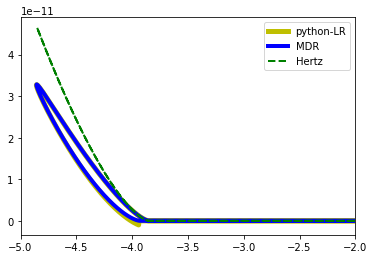

In [9]:
plt.plot((tip_lr - zb)*1.0e9, Fts_lr, 'y', lw=5, label = 'python-LR')
plt.plot( (tip_m-zb)*1.0e9, Fts_m, 'b', lw=4, label = 'MDR' )
alfa = 8.0/3.0*np.sqrt(R)/(1.0-nu)
#plt.plot((tip_lr - zb)*1.0e9, conv*alfa, 'r', lw=1.0, label='convolution-LR')
plt.plot((tp_h-zb)*1.0e9, Fts_h, 'g--', lw=2.0, label = 'Hertz')
plt.xlim(-5,-2)
plt.legend(loc=1)